In [63]:
import sklearn
import shap
import numpy as np
import pandas as pd
#Evalutation metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score
#Keeping track of time
from fastprogress.fastprogress import progress_bar
import matplotlib.pyplot as plt
import copy


In [152]:
#Churn dataset
url = 'https://github.com/EpistasisLab/pmlb/blob/master/datasets/churn/churn.tsv.gz?raw=true'
churn = pd.read_csv(url, compression='gzip', 
                                 header=0, sep = '\t', quotechar='"')

split = sklearn.model_selection.train_test_split(churn, shuffle=True)
X = split[0].drop('target', axis = 1)
Y = split[0].iloc[:, -1]
x = split[1].drop('target', axis = 1)
y = split[1].iloc[:, -1]

#This data comes from:
#Le, Trang T., William La Cava, Joseph D. Romano, John T. Gregg, Daniel J. Goldberg, Praneel Chakraborty, 
#Natasha L. Ray, Daniel Himmelstein, Weixuan Fu, and Jason H. Moore. 
#PMLB v1. 0: an open source dataset collection for benchmarking machine learning methods. arXiv preprint arXiv:2012.00058 (2020)


In [ ]:
clf = sklearn.ensemble.RandomForestClassifier()
clf = clf.fit(X,Y)
expl = shap.explainers.Tree(clf, X)
shap_vals = expl(x, check_additivity=False)
shap_vals[...,1]

In [7]:
# explainer = shap.explainers.Permutation(clf.predict, X)
# values = explainer(x)
# print(np.mean(values.values[...,1], axis = 0))
ranks = np.argsort(np.mean(np.abs(shap_vals.values[:,:,1]), axis = 0))
int(np.round(len(ranks)*0.10))
ranks[len(ranks)-2:len(ranks)]
ranks

array([ 2,  0, 14,  8, 11,  1,  3, 16, 15, 18, 13,  6,  5, 17, 10, 12,  4,
        9,  7, 19])

In [8]:
def train(clf, X, Y):
    #Iterate through the datasets and retrain for each
    temp = copy.deepcopy(clf)

    #Fit model
    temp.fit(X, Y)
    
    return temp

In [9]:
def metrics(clf, x, y):   
    #Get metrics: 
    yhat = clf.predict(x)

    accu = accuracy_score(y, yhat)
    accu_balanced = balanced_accuracy_score(y, yhat)
    f1 = f1_score(y, yhat)
        
    return np.array([[accu], [accu_balanced], [f1]])

In [10]:
def explain(clf, X, x, explainer = shap.explainers.Permutation):
    if explainer != shap.explainers.Tree:
        # #Build Explanation
        explanation = explainer(clf.predict, X)
        shap_values = explanation(x)
    else:
        # #Build Explanation
        explanation = explainer(clf, X)
        shap_values = explanation(x, check_additivity = False)
    #Get SHAP values for positive class
    shap_values = shap_values.values[...,1]
    shap_values = np.abs(shap_values)
    shap_values = np.mean(shap_values, axis= 0)
    #Get ranks
    ranks = np.argsort(shap_values)
    ranks
    return ranks

In [135]:
a = np.array([3,2,4,1])
np.argsort(a)

array([3, 1, 0, 2])

In [150]:
## Mask bottom features
def remove_bottom(t, rankings, X, Y, x, y, clf, base = np.empty((3,1))):
    
    #Make copies of our data to modify
    X_train = copy.deepcopy(X)
    x_test = copy.deepcopy(x)
    results = copy.deepcopy(base)

    #Set masking schedule
    j = int(np.round(len(rankings)*t))
    i = 0
    k = j
    
    #Mask and retrain
    while k <= len(rankings)+1:
        #Mask
        X_train.iloc[:, rankings[i:k]] = X_train.iloc[:, rankings[i:k]].mean()
        x_test.iloc[:, rankings[i:k]] = x_test.iloc[:, rankings[i:k]].mean() 
        #Retrain
        model = train(clf, X_train, Y)
        results =  np.hstack((results, metrics(model, x_test, y)))
        
        #Move iterator forward
        i += j
        k += j

    return results

# remove_bottom(0.10, ranks, X, Y, x, y, clf)

In [149]:
## Mask top features
def remove_top(t, rankings, X, Y, x, y, clf, base = np.empty((3,1))):
    #Make copies of our data to modify
    X_train = copy.deepcopy(X)
    x_test = copy.deepcopy(x)
    results = copy.deepcopy(base)
    
    
    #Set masking schedule
    j = int(np.round(len(rankings)*t))
    i = len(rankings) - j
    k = len(rankings)
    
    #Mask and retrain
    while k >= j:
        #Mask
        X_train.iloc[:, rankings[i:k]] = X_train.iloc[:, rankings[i:k]].mean()
        x_test.iloc[:, rankings[i:k]] = x_test.iloc[:, rankings[i:k]].mean() 
            
        #Retrain
        model = train(clf, X_train, Y)
        results =  np.hstack((results, metrics(model, x_test, y)))
        
        
        #Move iterator forward
        i -= j
        k -= j

    return results


# remove_top(0.10, ranks, X, Y, x, y, clf)

In [147]:
## Mask random features
def remove_random(t, rankings, X, Y, x, y, clf, base = np.empty((3,1))):
    
    random_choices = np.random.choice(len(rankings), len(rankings), replace = False)

    #Make copies of our data to modify
    X_train = copy.deepcopy(X)
    x_test = copy.deepcopy(x)
    results = copy.deepcopy(base)
    
    #Set masking schedule
    j = int(np.round(len(random_choices)*t))
    i = 0
    k = j
    
    #Mask and retrain
    while k <= len(random_choices):
        #Mask
        X_train.iloc[:, random_choices[i:k]] = X_train.iloc[:, random_choices[i:k]].mean()
        x_test.iloc[:, random_choices[i:k]] = x_test.iloc[:, random_choices[i:k]].mean() 
            
        #Retrain
        model = train(clf, X_train, Y)
        results = np.hstack((results, metrics(model, x_test, y)))
       


        #Move iterator forward
        i += j
        k += j

    return results

# remove_random(0.10, ranks, X, Y, x, y, clf)

In [226]:
def roar(X, Y, x, y, clf, explainer = shap.explainers.Permutation, t = 0.10, repeats = 2):
    #Initialize the frames
    model = train(clf, X, Y)
    base = metrics(model, x, y)
    #Initialize
    ranks = explain(model, X, x, explainer)
     
    top = remove_top(t, ranks, X, Y, x, y, clf, base)
    bottom = remove_bottom(t, ranks, X, Y, x, y, clf, base)
    random = remove_random(t, ranks, X, Y, x, y, clf, base)

    #Set progress bar
    mb = progress_bar(range(repeats - 1))
    #Repeat x times
    for i in mb:
        ranks = explain(model, X, x, explainer)
        top = np.dstack((top, remove_top(t, ranks, X, Y, x, y, clf, base)))
        bottom = np.dstack((bottom, remove_bottom(t, ranks, X, Y, x, y, clf, base)))
        random = np.dstack((random, remove_random(t, ranks, X, Y, x, y, clf, base)))
    return np.array([top, bottom, random])

In [227]:
test = roar(X, Y, x, y, clf = sklearn.ensemble.RandomForestClassifier(), explainer = shap.explainers.Tree, t = 0.10, repeats = 10)

 96%|=================== | 2405/2500 [00:24<00:00]       

Top
Bottom
Random


 98%|===================| 2455/2500 [00:25<00:00]        

In [156]:
#ROAR returns an array of the following shape (3, metrics,  steps, iterations)
#shape[0] is top, bottom, random
#shape[1] is the surveyed metrics, in this case: accuracy, balanced accuracy, f1
#shape[2] is the # of steps that had to be done to mask all of the features
#shape[3] is the number of iterations ran
print(test.shape)

#np.mean(roar_results, axis = 3) returns the average scores over all repeats.
print(np.mean(test, axis = 3).shape)

results_mean = np.mean(test, axis = 3)
auc = np.trapz(results_mean)
print(auc)
diff = auc[1] - auc[0]
print(diff)





(3, 3, 11, 2)
(3, 3, 11)
[[8.5632     5.30693074 0.87512532]
 [9.122      7.60314492 6.34411095]
 [9.1188     7.60677203 6.34319362]]
[0.5588     2.29621418 5.46898563]


In [187]:
#Returns the ROAR score for each metric: accuracy, balanced_accuracy, f1
def roar_score(results):
    results_mean = np.mean(test, axis = 3)
    auc = np.trapz(results_mean)
    score = np.where((auc[1] - auc[0]) < 0,  (auc[1] - auc[0])/auc[0], (auc[1] - auc[0])/auc[1])
    return score

In [218]:
print(roar_score(test))

[0.0612585  0.30200847 0.86205706]


0.862776025236593

In [123]:
print(test.shape)
test.mean(axis = 3).shape

(3, 3, 11, 2)


(3, 3, 11)

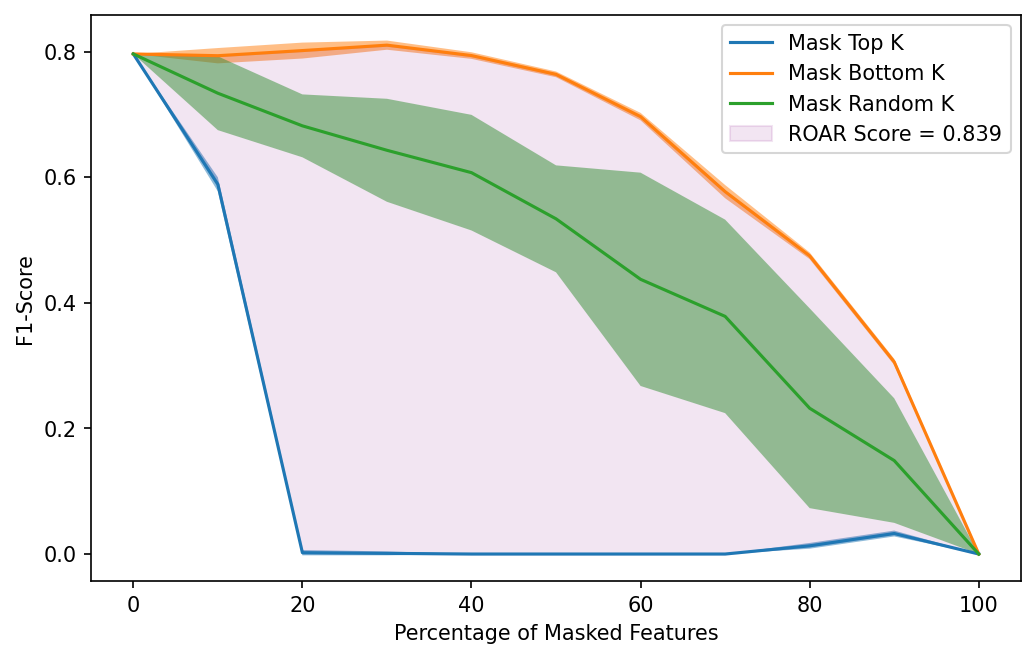

In [237]:

def plot_roar(results, metric = 'Balanced_Accuracy'):
    metrics = {'Accuracy':0, 'Balanced_Accuracy':1, 'F1-Score':2}
    i = metrics[metric]

    results_mean = np.mean(results, axis = 3)
    results_std = np.std(results, axis = 3)
    plus = results_mean + results_std
    minus = results_mean - results_std

    a = np.linspace(0, 100, num = len(results_mean[0][0]))

    plt.figure(figsize=(8,5), dpi = 150)
    plt.plot(a, results_mean[0][i], label = 'Mask Top K')
    plt.plot(a, results_mean[1][i], label = 'Mask Bottom K')
    plt.plot(a, results_mean[2][i], label = 'Mask Random K')

    plt.fill_between(a, y1 = plus[0][i], y2 = minus[0][i], alpha = 0.5)
    plt.fill_between(a, y1 = plus[1][i], y2 = minus[1][i], alpha = 0.5)
    plt.fill_between(a, y1 = plus[2][i], y2 = minus[2][i], alpha = 0.5)

    plt.fill_between(a, y1 = results_mean[0][i], y2 = results_mean[1][i], label = f'ROAR Score = {np.round(roar_score(results)[i], decimals= 3)}', alpha = 0.1, color= 'purple')

    plt.xlabel('Percentage of Masked Features')
    plt.ylabel(f'{metric}')

    plt.legend()

    plt.show()

plot_roar(test, metric='F1-Score')